## Deep Learning Version , oversampled

In [1]:
#imports
import time
start_time = time.time()
import numpy as np
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.metrics import binary_accuracy
#from keras.utils import np_utils
print("--- %s seconds ---" % (time.time() - start_time))

Using TensorFlow backend.


--- 6.443789720535278 seconds ---


In [2]:
# import datasets with time taken!
#smoll
""" # commented out to save computation
start_time = time.time()
smoll = np.loadtxt("/home/willett/NeutrinoData/small_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(smoll.shape)
"""

#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/full_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)


""" # commented out to save computation
#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/test_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)
"""

# extract title
pls = open("/home/willett/NeutrinoData/small_CNN_input_processed.txt", "r")
title = pls.readline()
title = title[2:-1]
print(title)

--- 2.2729129791259766 seconds ---
(46280, 21)
 FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M  FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  Energy_As  Angle_Bet  Distance_Bet   Sig   Bg


In [3]:
# creating a dataset switch, change what UsedData is to change CNN
UD = fll # Used Data = <dataset>
UDLength = UD.shape[0]
print("shape: ",UD.shape,"\nsize: ", UD.size," \nlength: ", UDLength)

# dataset is expected in this format:
# FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M
#FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  
#Energy_As  Angle_Bet  Distance_Bet   Sig   Bg

# with Sig and Bg expected as one hot vectors.

shape:  (46280, 21) 
size:  971880  
length:  46280


In [4]:
# splitting X = dataset , Y = one hot vectors
X = UD[:,0:-2]
Y = UD[:,-2:1000]
print("X shape: ",X.shape,"\nY shape: ", Y.shape)

# they will be split into testing and training at compile

X shape:  (46280, 19) 
Y shape:  (46280, 2)


In [5]:
# inevitable bias removal... by oversampling
# using a 50% oversampling ratio, because i want to ! (no citation)

#how long?
start_time = time.time()

SigI = np.where(Y[:,0] == 1)[0] 
BgI= np.where(Y[:,0] == 0)[0]
SigN = SigI.size       # how much signal there is
BgN = BgI.size         # how much background there is
Multip = int(BgN/SigN) # how much more signal event copies needed for ~50%
print(" signal and background event number: ",SigI.size,BgI.size,"\n number more needed:",Multip)
SNratio =  (100*SigN)/(SigN + BgN)
print("initial Signal to Noise ratio: ",SNratio,"% signal")

#im going to reconstruct the arrays of signal events, background events, then add them together and shuffle!

XSig = X[SigI]
XBg = X[BgI]
YSig = Y[SigI]
YBg = Y[BgI]
#print(XSig.shape,XBg.shape, YSig.shape, YBg.shape) # these are the events of each type.

# this is the array of signal repreated (tiled) multip times.
YSigM = np.transpose(np.tile(np.transpose(YSig), Multip))
XSigM = np.transpose(np.tile(np.transpose(XSig), Multip)) 
print( XSigM.shape, YSigM.shape)

#adding arrays together and then shuffling:
X2 = np.concatenate((XBg,XSigM))
Y2 = np.concatenate((YBg,YSigM))
print(X2.shape, Y2.shape)

#shuffling
print("these arrays should be different vertically, to ensure shuffle succesful:")
print(X2[0:3,0],Y2[0:3,0])
np.random.shuffle(X2)
np.random.shuffle(Y2)
print(X2[0:3,0],Y2[0:3,0])

#final ratio:
NewSigN = YSigM.shape[0]
SNRatioNew = (100*YSigM.shape[0]) / (YSigM.shape[0] + BgN)
print("final Signal Noise ratio: ",SNRatioNew,"% signal")

print("--- %s seconds ---" % (time.time() - start_time))


 signal and background event number:  1148 45132 
 number more needed: 39
initial Signal to Noise ratio:  2.4805531547104582 % signal
(44772, 19) (44772, 2)
(89904, 19) (89904, 2)
these arrays should be different vertically, to ensure shuffle succesful:
[0.00829848 0.0039091  0.00049919] [0. 0. 0.]
[0.00210855 0.0002447  0.00024218] [1. 1. 1.]
final Signal Noise ratio:  49.799786438868125 % signal
--- 0.38234734535217285 seconds ---


In [26]:
print(X2.shape)
X3 = np.expand_dims(X2, axis=2)
print(X3.shape)


(89904, 19)
(89904, 19, 1)


In [38]:


#neural network architecture:
model = Sequential()

# set variables:
width = 8 #--number on nodes in the layer
DR = 0.5 #--fraction of nodes dropped during training
AT = "sigmoid" #--activation type for dense layers
UB = True #--use bias vectors 
InDim = (X3.shape[1],X3.shape[2] ) #--input shape of single sample (tuple)

#construction:
start_time = time.time() # how long does it take?
model.add(Dense(width,activation=AT, use_bias=UB, input_shape=(19,1) )) # input layer and 1
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 2
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 3
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 4
model.add(Dropout(DR))

model.add(Flatten())  # reduce dimensionality of the input data for output

model.add(Dense(2, activation="softmax", use_bias=UB)) # output layer softmax recommended 
#(classification mutually excluive + softmax differentiable for optimizing)
# -> https://www.quora.com/Artificial-Neural-Networks-Why-do-we-use-softmax-function-for-output-layer
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.38596105575561523 seconds ---


In [39]:
# Apply regularizer if overfitting! ^

# binary_crossentropy is the best according to https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/
# adam is best for me according to https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f

In [45]:
# compile model:
start_time = time.time() # how long does it take?
model.compile(optimizer='nadam',            
              loss='binary_crossentropy',               
              metrics=['accuracy', 'binary_accuracy' ])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.722191333770752 seconds ---


In [48]:
# Train the model, iterating on the data in batches of 32 samples

start_time = time.time()             # how long does it take?
history = model.fit(X3,              # the (now oversampled) dataset
          Y2,                        #true or false values for the dataset 
          epochs=50,                 #number of iteration over data
          batch_size=32,             #number of trainings between tests
          verbose=1,                 #prints one line per epoch of progress bar
          validation_split=0.1 )     #ratio of test to train

print("--- %s seconds ---" % (time.time() - start_time))

Train on 80913 samples, validate on 8991 samples
Epoch 1/50
80913/80913 [==============================] - 11s 132us/step - loss: 0.6933 - acc: 0.4982 - binary_accuracy: 0.4982 - val_loss: 0.6931 - val_acc: 0.5047 - val_binary_accuracy: 0.5047
Epoch 2/50
80913/80913 [==============================] - 12s 147us/step - loss: 0.6932 - acc: 0.5027 - binary_accuracy: 0.5027 - val_loss: 0.6931 - val_acc: 0.5047 - val_binary_accuracy: 0.5047
Epoch 3/50
80913/80913 [==============================] - 12s 148us/step - loss: 0.6932 - acc: 0.5018 - binary_accuracy: 0.5018 - val_loss: 0.6931 - val_acc: 0.5047 - val_binary_accuracy: 0.5047
Epoch 4/50
80913/80913 [==============================] - 13s 158us/step - loss: 0.6933 - acc: 0.4969 - binary_accuracy: 0.4969 - val_loss: 0.6932 - val_acc: 0.4953 - val_binary_accuracy: 0.4953
Epoch 5/50
80913/80913 [==============================] - 13s 155us/step - loss: 0.6932 - acc: 0.5010 - binary_accuracy: 0.5010 - val_loss: 0.6933 - val_acc: 0.4953 - val_

80913/80913 [==============================] - 18s 227us/step - loss: 0.6933 - acc: 0.4995 - binary_accuracy: 0.4995 - val_loss: 0.6931 - val_acc: 0.5047 - val_binary_accuracy: 0.5047
Epoch 43/50
80913/80913 [==============================] - 19s 236us/step - loss: 0.6932 - acc: 0.4990 - binary_accuracy: 0.4990 - val_loss: 0.6931 - val_acc: 0.5047 - val_binary_accuracy: 0.5047
Epoch 44/50
80913/80913 [==============================] - 17s 211us/step - loss: 0.6932 - acc: 0.5017 - binary_accuracy: 0.5017 - val_loss: 0.6932 - val_acc: 0.4953 - val_binary_accuracy: 0.4953
Epoch 45/50
80913/80913 [==============================] - 19s 229us/step - loss: 0.6932 - acc: 0.4985 - binary_accuracy: 0.4985 - val_loss: 0.6931 - val_acc: 0.5047 - val_binary_accuracy: 0.5047
Epoch 46/50
80913/80913 [==============================] - 20s 242us/step - loss: 0.6933 - acc: 0.4988 - binary_accuracy: 0.4988 - val_loss: 0.6933 - val_acc: 0.4953 - val_binary_accuracy: 0.4953
Epoch 47/50
80913/80913 [=======

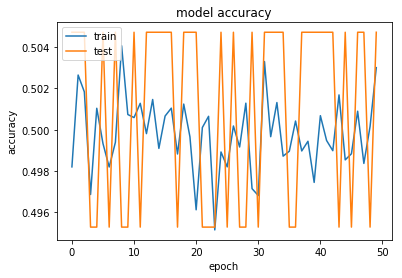

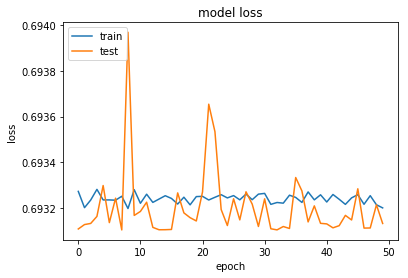

In [49]:
#summarise history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()